# Convex hull as an index to support an algorithm for the mutualisation of itineraires - to see it renderd visit https://nbviewer.org/github/Universite-Gustave-Eiffel/geodev-logicout/blob/Thiago/notebooks/convex_hull.ipynb

In [13]:
import sys  
sys.path.insert(0, '../scripts')
import jacaard, use_data, IsInclude
from shapely import wkt
import geopandas as gpd
import seaborn as sns

In [14]:
# we initialize the parameters for the geodataframe
radius=100000
buffer_hull= 1000
type= 1
geo_df= use_data.create_gdf('simulations_reel_gdf.csv','cheflieu')

##We will take some itineraires and their mutualisables itineraires as examples to visualize how the convexes hulls behaves

Number of labels: 100


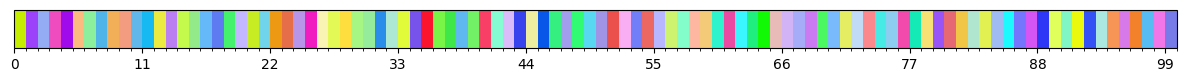

In [15]:
# We Generate random colormap using the module created by https://github.com/delestro/rand_cmap

def rand_cmap(nlabels, type='bright', first_color_black=True, last_color_black=False, verbose=True):
    from itertools import cycle # to generate random colors
    """
    Creates a random colormap to be used together with matplotlib. Useful for segmentation tasks
    :param nlabels: Number of labels (size of colormap)
    :param type: 'bright' for strong colors, 'soft' for pastel colors
    :param first_color_black: Option to use first color as black, True or False
    :param last_color_black: Option to use last color as black, True or False
    :param verbose: Prints the number of labels and shows the colormap. True or False
    :return: colormap for matplotlib
    """
    from matplotlib.colors import LinearSegmentedColormap
    import colorsys
    import numpy as np

    if type not in ('bright', 'soft'):
        print ('Please choose "bright" or "soft" for type')
        return

    if verbose:
        print('Number of labels: ' + str(nlabels))

    # Generate color map for bright colors, based on hsv
    if type == 'bright':
        randHSVcolors = [(np.random.uniform(low=0.0, high=1),
                          np.random.uniform(low=0.2, high=1),
                          np.random.uniform(low=0.9, high=1)) for i in range(nlabels)]

        # Convert HSV list to RGB
        randRGBcolors = []
        for HSVcolor in randHSVcolors:
            randRGBcolors.append(colorsys.hsv_to_rgb(HSVcolor[0], HSVcolor[1], HSVcolor[2]))

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]

        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Generate soft pastel colors, by limiting the RGB spectrum
    if type == 'soft':
        low = 0.6
        high = 0.95
        randRGBcolors = [(np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high)) for i in xrange(nlabels)]

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]
        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Display colorbar
    if verbose:
        from matplotlib import colors, colorbar
        from matplotlib import pyplot as plt
        fig, ax = plt.subplots(1, 1, figsize=(15, 0.5))

        bounds = np.linspace(0, nlabels, nlabels + 1)
        norm = colors.BoundaryNorm(bounds, nlabels)

        cb = colorbar.ColorbarBase(ax, cmap=random_colormap, norm=norm, spacing='proportional', ticks=None,
                                   boundaries=bounds, format='%1i', orientation=u'horizontal')

    return random_colormap
new_cmap = rand_cmap(100, type='bright', first_color_black=False, last_color_black=False, verbose=True)


In [16]:
sample1=geo_df.iloc[[5]] #we choose a sample itineraire as a sample

#this function will return a map and a geodataframe consisting of all mutualisables itineraires for the given sample
def return_map_and_dataframe(sample, dataframe):

    gdf=gpd.GeoDataFrame(sample,geometry=sample['start'].map(wkt.loads))
    m= gdf.explore(tiles='CartoDB positron',style_kwds=dict(fill=False, stroke=True,weight=4,color='black'))

    gdf=gpd.GeoDataFrame(gdf,geometry=gdf['itineraire'].map(wkt.loads))
    m= gdf.explore(m=m,tiles='CartoDB positron',style_kwds=dict(fill=False, stroke=True,weight=2,color='black')) #to build the map
    
    geometry = gdf['cheflieu'].map(wkt.loads)
    cheflieu = gpd.GeoDataFrame(gdf, geometry=geometry, crs = 'EPSG:2154') # we get the center of the cheflieu as a geometry
    cheflieu['buffer'] = cheflieu.geometry.buffer(100000) # create the buffer based on the cheflieu point
    cheflieu = gpd.GeoDataFrame(cheflieu, geometry='buffer')
    print(cheflieu.geometry)
    m = cheflieu.explore(m=m,tiles='CartoDB positron',style_kwds=dict(fill=False, stroke=True,weight=2,color='black'))

    gdf = IsInclude.IsIn_tournee_gdf(gdf,dataframe,100000,1) #we check the allowed itineraires

    gdf = gpd.GeoDataFrame(gdf, geometry=gdf['start_right'].map(wkt.loads), crs='EPSG: 2154')
    m = gdf.reset_index().explore(m=m,tiles='CartoDB positron', cmap = new_cmap,column='id_simulation_right', categorical=True,style_kwds=dict(fill=False, stroke=True,weight=5))
    
    gdf = gpd.GeoDataFrame(gdf, geometry=gdf['itineraire_right'].map(wkt.loads), crs='EPSG: 2154')
    m = gdf.reset_index().explore(m=m,tiles='CartoDB positron', cmap = new_cmap, column='id_simulation_right', categorical=True,
                                style_kwds=dict(opacity=0.5))
    return m, gdf

sample_map, sample_gdf =return_map_and_dataframe(sample1,geo_df)


5    POLYGON ((794296.200 6782889.900, 793814.673 6...
Name: buffer, dtype: geometry


In [17]:
sample_map # in black the itineraire of the chosen sample


We can also choose a sample by the simulation's Id

In [18]:
sample2 = geo_df[geo_df['id_simulation']==13933]
sample2_map, sample2_dataframe = return_map_and_dataframe(sample2,geo_df)

821    POLYGON ((755619.900 6827662.700, 755138.373 6...
Name: buffer, dtype: geometry


Let's look at their convex hulls within a radius of 1km of the lines representing the itineraires

In [19]:
sample2_gdf= IsInclude.IsIn_tournee_gdf(sample2,geo_df,radius,type)
sample2_envelopes = jacaard.jacaard_index(sample2, sample2_gdf,buffer_hull)
sample2 = gpd.GeoDataFrame(sample2,geometry=sample2['itineraire'].map(wkt.loads)) # type: ignore
sample2 = gpd.GeoDataFrame(sample2,geometry=sample2.geometry.buffer(1000).convex_hull) # type: ignore

In [20]:
m = sample2.explore(tiles='CartoDB positron',style_kwds=dict(fill=True,opacity=0.5, stroke=True,weight=4,color='black'))
m = sample2_envelopes.explore(
    m=m,tiles='CartoDB positron', cmap = new_cmap,column='id_simulation_right', categorical=True,style_kwds=dict(fill=True, stroke=True,weight=2))

In [21]:
m

##Quantification of convex hulls overlays

In [22]:
# the Jaacard's index gives an measure of similarity between two sets. If the sets are disjoints, the index is 0, and If they're the same, the index is 1.
sample2_envelopes['jaacard'].describe()

count    32.000000
mean      0.019321
std       0.053246
min       0.000000
25%       0.000000
50%       0.000000
75%       0.007724
max       0.272498
Name: jaacard, dtype: float64

For this sample this index seems to be usefull for the purpose of selecting the best pairs of itineraires. 
It may miss itineraires that doesn't forcefully intersect each others but that could have been enchained.
Let's see how well it behaves for all the db.

In [23]:
#this takes aproximatly 3 minutes to run
import pandas as pd
empty_list=[]
for i in range (geo_df.shape[0]):
    gdf= IsInclude.IsIn_tournee_gdf(geo_df.iloc[[i]],geo_df,radius,type)
    gdf = jacaard.jacaard_index(geo_df.iloc[[i]], gdf,buffer_hull)
    empty_list = empty_list + gdf.values.tolist()

    
df = pd.DataFrame (empty_list, columns = ['id_simulation','id_simulation_right','itineraire_right','start_right','union_area','intersection_area','geometry','jaacard'])

df_not_null = df[df['jaacard']!=0]



In [32]:
jacard_table=df.groupby('id_simulation')
jacard_table['jaacard'].count()

id_simulation
1000       5
10190    220
10191    220
10380    219
10382    219
        ... 
995        5
996        5
997        5
998        5
999        5
Name: jaacard, Length: 1096, dtype: int64

In [33]:
jacard_table_not_null=df_not_null.groupby('id_simulation')
jacard_table_not_null['jaacard'].count()

id_simulation
349       6
473      16
474       5
483      14
640       3
         ..
18917    15
18918     9
18919    28
18920    17
18935     5
Name: jaacard, Length: 916, dtype: int64

Roughly 16% of the database's entries didn't have any non-zero value. As for the others, the quantity of potentially mutualisables itineraires has been greatly reduced.

In [34]:
print('Total of mutualisation searched: {0}'.format(df.shape[0]))
print('Total of mutualisation searched with jacaard index > 0: {0}'.format(df_not_null.shape[0]))

Total of mutualisation searched: 77344
Total of mutualisation searched with jacaard index > 0: 18913


##Plot of the distributions of the jacaard indexes

[Text(0.5, 1.0, 'Valid mutualisations considering all entries')]

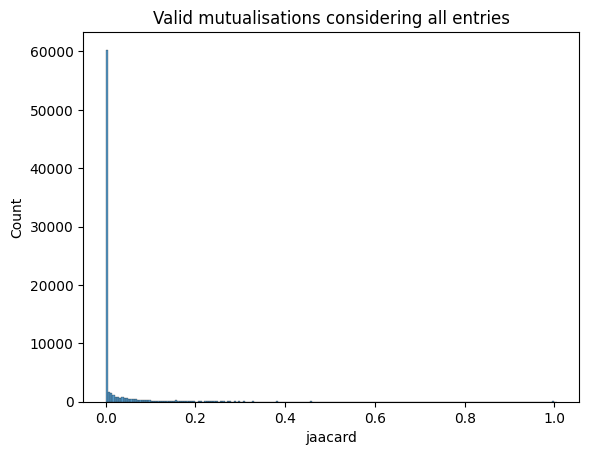

In [35]:

df['id_simulation']=df['id_simulation'].map(str) # we will convert the id_simulation in a categorical data
df_histo=df[['id_simulation','jaacard']]
sns.histplot(data=df_histo,x="jaacard", legend=False,binwidth=0.005).set(title='Valid mutualisations considering all entries')

[Text(0.5, 1.0, 'Valid mutualisations considering all entries with jacaard index > 0')]

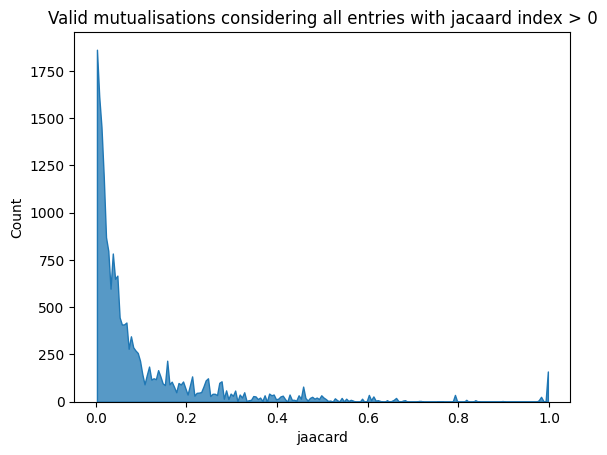

In [36]:

df_histo_not_null=df_not_null[['id_simulation','jaacard']]
sns.histplot(data=df_histo_not_null,x="jaacard", element="poly", legend=False,binwidth=0.005).set(title='Valid mutualisations considering all entries with jacaard index > 0')

We can inspect the list of itineraires that don't have any overlapping convex hull

In [37]:
jaacard_full=jacard_table.count().index.values
jacaard_not_empty=jacard_table_not_null.count().index.values
difference = [x for x in jaacard_full if x not in jacaard_not_empty]
print(difference)

['1000', '10190', '10191', '10380', '10382', '10383', '10391', '10394', '10442', '10527', '10528', '10602', '10603', '10604', '10605', '10606', '10621', '1065', '10683', '10684', '10693', '10694', '10719', '10725', '10728', '10729', '10732', '10737', '10739', '10740', '10742', '10777', '10778', '10812', '10826', '10828', '10829', '10830', '10834', '10844', '10855', '10860', '10861', '10863', '10864', '10865', '10867', '10868', '1087', '10872', '10921', '10922', '10938', '10941', '11059', '11060', '11062', '11063', '11118', '11127', '11169', '1121', '11239', '11264', '11265', '11268', '11269', '11273', '11275', '11276', '11277', '11278', '11279', '11280', '1129', '11294', '11299', '1131', '1132', '11341', '11342', '11360', '11375', '11392', '11425', '11431', '11432', '11433', '11434', '11435', '11444', '11449', '11451', '11590', '11592', '11593', '11595', '11612', '11616', '11619', '11634', '11635', '11636', '11637', '11638', '11639', '11640', '11668', '11669', '11670', '11689', '11690'

/tmp/ipykernel_829/2100271317.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  difference = [x for x in jaacard_full if x not in jacaard_not_empty]


Let's see the simulation with id 939

In [38]:
sample3 = geo_df[geo_df['id_simulation']==1466]
sample3_map, sample3_dataframe = return_map_and_dataframe(sample3,geo_df)

sample3_gdf= IsInclude.IsIn_tournee_gdf(sample3,geo_df,radius,type)
sample3_envelopes = jacaard.jacaard_index(sample3, sample3_gdf,buffer_hull)
sample3 = gpd.GeoDataFrame(sample3,geometry=sample3['itineraire'].map(wkt.loads)) 
sample3 = gpd.GeoDataFrame(sample3,geometry=sample3.geometry.buffer(1000).convex_hull) 


m = sample3.explore(tiles='CartoDB positron',style_kwds=dict(fill=True,opacity=0.5, stroke=True,weight=4,color='black'))
m = sample3_envelopes.explore(
    m=m,tiles='CartoDB positron', cmap = new_cmap,column='id_simulation_right', categorical=True,style_kwds=dict(fill=True, stroke=True,weight=2))

73    POLYGON ((606316.300 6939358.800, 605834.773 6...
Name: buffer, dtype: geometry


In [39]:
m

Considering this simulations and others, we can think that the index based in the overlapping's convex hulls can be useful but it's not enough to find the best pairs of itineraires, so it should be used to complement other strategies. 
Nonetheless, it could have a high covariance with others indexes of similarity and thus not being highly effective.

In [128]:
sample5 = geo_df[geo_df['id_simulation']==11449]
gdf=gpd.GeoDataFrame(sample5,geometry=sample5['start'].map(wkt.loads))
m= gdf.explore(tiles='CartoDB positron',style_kwds=dict(fill=False, stroke=True,weight=4,color='black'))
gdf=gpd.GeoDataFrame(sample5,geometry=sample5['itineraire'].map(wkt.loads))
m= gdf.explore(m=m,tiles='CartoDB positron',style_kwds=dict(fill=False, stroke=True,weight=2,color='black'))


sample6 = geo_df[geo_df['id_simulation']==16316]
gdf=gpd.GeoDataFrame(sample6,geometry=sample6['start'].map(wkt.loads))
m= gdf.explore(m=m,tiles='CartoDB positron',style_kwds=dict(fill=False, stroke=True,weight=4,color='red'))
gdf=gpd.GeoDataFrame(sample6,geometry=sample6['itineraire'].map(wkt.loads))
m= gdf.explore(m=m,tiles='CartoDB positron',style_kwds=dict(fill=False, stroke=True,weight=2,color='red'))

In [130]:
output= "mutualisables.html"
m.save(output)

In [141]:
from shapely.geometry import Point, LineString, shape
coords = [( .794952 , 48.73988) ,
 (3.34214  , 48.727256),
 (3.270993 , 48.698888),
 (3.179958 , 48.715268),
 (2.813542 , 48.865042),
 (2.68861  , 48.86917 ),
 (2.496039 , 48.793714),
 (2.474872 , 48.805443),
 (2.436658 , 48.847639),
 (2.444228 , 48.863774),
 (2.393881 , 48.857115),
 (2.27961  , 48.870104),
 (2.304367 , 48.813179),
 (2.215943 , 48.640844),
 (2.498608 , 48.703466),
 (2.557781 , 48.67711 ),
 (2.615411 , 48.744032)]
optimized = LineString (coords)

SyntaxError: invalid syntax (721190221.py, line 2)

In [133]:
mutualise = ['example']
info= ['info1']  

  
# Create the pandas DataFrame with column name is provided explicitly
df = pd.DataFrame(columns=['A','geometry'])
df['A'] = info
df['geometry'] = optimized

In [134]:
gdf = gpd.GeoDataFrame(df, geometry='geometry' crs='EPSG: 4326')

In [135]:
gdf['geometry'] = gdf.geometry.to_crs(2154)

In [136]:
gdf.reset_index()

,index,A,geometry
0,0,info1,"LINESTRING (672666.636 2129759.644, 745615.276..."


In [137]:
mappe = gdf.explore(tiles='CartoDB positron')

In [138]:
mappe

output= "mutualises.html"
mappe.save(output)

In [139]:
sample2.geometry

821    POLYGON ((695255.896 6790729.850, 695156.397 6...
Name: geometry, dtype: geometry

In [140]:
gdf.geometry

0    LINESTRING (672666.636 2129759.644, 745615.276...
Name: geometry, dtype: geometry